In [1]:
import joblib
from sklearn.metrics import accuracy_score
import numpy as np
from facenet_pytorch import fixed_image_standardization
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from PIL import Image
from retinaface import RetinaFace
import torch
import pickle
import os
from sklearn.metrics import accuracy_score
from facenet_pytorch import InceptionResnetV1
device="mps" if torch.backends.mps.is_available() else "cpu"
print(f"device being used is {device}")
model = InceptionResnetV1(pretrained='vggface2', dropout_prob=0.5, device=device).eval()
model

device being used is mps


InceptionResnetV1(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

In [2]:
with open('data/class_list.pkl', 'rb') as file:
    ClassList = pickle.load(file)
    
def name_from_index(i, ClassList=ClassList):
    reversed_dict = {v: k for k, v in ClassList.items()}
    if isinstance(i, np.ndarray):  # Check if i is a NumPy array
        names = [reversed_dict.get(idx.item(), None) for idx in i]
        return names
    else:
        return reversed_dict.get(i, None)
standard_transform = transforms.Compose([
                                np.float32,
                                transforms.ToTensor(),
                                fixed_image_standardization,
                                transforms.Resize([224, 224],antialias=None )
])

In [3]:
SVM_PATH = os.path.join("data", 'svm50.sav')
clf = joblib.load(SVM_PATH)
DATA_PATH="data/Embedings"
TRAIN_EMBEDS = os.path.join(DATA_PATH, 'trainEmbeds.npz')
TEST_EMBEDS = os.path.join(DATA_PATH, 'testEmbeds.npz')
trainEmbeds, trainLabels = np.load(TRAIN_EMBEDS, allow_pickle=True).values()
testEmbeds, testLabels = np.load(TEST_EMBEDS, allow_pickle=True).values()
X_test, y_test = np.copy(testEmbeds), np.array([name_from_index(label) for label in testLabels])
test_acc = accuracy_score(clf.predict(X_test), y_test)
print(f'Accuracy score on test data: {test_acc}')

Accuracy score on test data: 0.8865979381443299


In [4]:
%%time
img="data/exp/WhatsApp Image 2024-01-12 at 23.21.21.jpeg"
image=Image.open(img)
image=np.array(image)
o = RetinaFace.detect_faces(img)
coordinates=o["face_1"]["facial_area"]
x,y,w,h=coordinates
image[x:w]
imgf=image[y:h, x:w]
imgf=standard_transform(imgf)
imgf=model(imgf.to(device).unsqueeze(0))
print(clf.predict(imgf.cpu().detach().numpy())[0])
decision_values = clf.decision_function(imgf.cpu().detach().numpy())
decision_values

Ritansh Singhal
CPU times: user 12.4 s, sys: 928 ms, total: 13.3 s
Wall time: 4.1 s


array([[ 0.78232041,  6.28600075,  2.88521077,  5.11366428,  4.22984252,
        -0.27683832,  1.80145242]])

///
[[ 1.75757388  0.74260906  6.28003821  3.04179497  5.26485411 -0.26241162
   4.10970306]]
the predicted index is 2


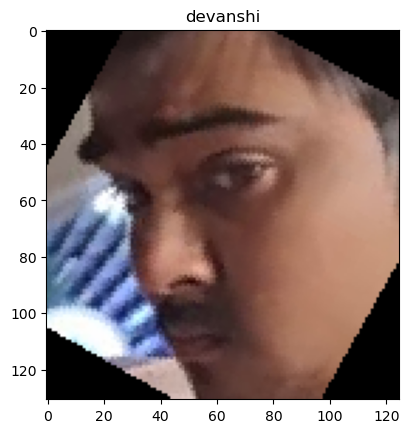

///


In [5]:
img_path="data/exp/WhatsApp Image 2024-01-23 at 10.02.16.jpeg"
import matplotlib.pyplot as plt
faces = RetinaFace.extract_faces(img_path = img_path, align = True)
for i in range(len(faces)):
    print("///")
    imgf=standard_transform(faces[i])
    imgf=model(imgf.to(device).unsqueeze(0))
    decision_values = clf.decision_function(imgf.cpu().detach().numpy())
    print(decision_values)
    
    prediction=clf.predict(imgf.cpu().detach().numpy())[0]
    print(f"the predicted index is {ClassList[prediction]}")
    plt.imshow(faces[i])
    plt.title(prediction)
    plt.show()
    print("///")


In [6]:
ClassList

{'Nischal': 0,
 'Ritansh Singhal': 1,
 'devanshi': 2,
 'kamlendra': 3,
 'mradul': 4,
 'palak': 5,
 'tanishk': 6}